In [93]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
## load data
water_pumps = pd.read_csv('data/water_pump_set.csv', index_col='id', parse_dates=['date_recorded'])
water_pumps_labels = pd.read_csv('data/water_pump_labels.csv', index_col='id', dtype={'status_group': 'category'})

## join dataframes on index
water_pumps_df = water_pumps.join(water_pumps_labels)

# water_pumps_df.info()

In [97]:
############# EDA: EXPLORATORY DATA ANALYSIS #############
## data cleaning 
# count overlapping values between two similar columns
extraction_overlap = (sum(np.where(water_pumps_df['extraction_type'] == water_pumps_df['extraction_type_group'], True, False)) / len(water_pumps_df)) * 100
print("{:.1f}% matching values between columns 'extraction_type' and 'extraction_type_group'".format(extraction_overlap))

quantity_overlap = (sum(np.where(water_pumps_df['quantity'] == water_pumps_df['quantity_group'], True, False)) / len(water_pumps_df)) * 100
print("{:.1f}% matching values between columns 'quantity' and 'quantity_group'".format(quantity_overlap))

waterpoint_overlap = (sum(np.where(water_pumps_df['waterpoint_type'] == water_pumps_df['waterpoint_type_group'], True, False)) / len(water_pumps_df)) * 100
print("{:.1f}% matching values between columns 'waterpoint_type' and 'waterpoint_type_group'".format(waterpoint_overlap))

# count number of occurrences of unique values
print(water_pumps_df['management_group'].value_counts())

# check for duplicate columns (but different category names)
print(water_pumps_df['payment_type'].value_counts())
print(water_pumps_df['payment'].value_counts())

print(water_pumps_df['water_quality'].value_counts())
print(water_pumps_df['quality_group'].value_counts())

print(water_pumps_df['source'].value_counts())
print(water_pumps_df['source_type'].value_counts())

# drop unuseful columns
water_pumps_df = water_pumps_df.drop(columns=['funder', 'region', 'num_private', 'recorded_by', 'scheme_name', 'extraction_type_group', 'management_group', 'payment', 'quantity_group', 'quality_group', 'source_type', 'waterpoint_type_group'])

# set incorrect values to nan
# water_pumps_df['construction_year'] = water_pumps_df['construction_year'].replace(0, np.nan)
water_pumps_df['longitude'] = water_pumps_df['longitude'].replace(0, np.nan)

# water_pumps_df.info()

95.8% matching values between columns 'extraction_type' and 'extraction_type_group'
100.0% matching values between columns 'quantity' and 'quantity_group'
89.7% matching values between columns 'waterpoint_type' and 'waterpoint_type_group'
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride a

In [98]:
## set dtypes
# convert columns to bool
to_bool = ['public_meeting', 'permit']
water_pumps_df[to_bool] = water_pumps_df[to_bool].astype('boolean')

# convert some numeric columns to categorical
to_categorical = ['district_code', 'region_code']
water_pumps_df[to_categorical] = water_pumps_df[to_categorical].astype('category')

# set remaining (non-numeric) columns to categorical
to_categorical = water_pumps_df.select_dtypes(include='object').columns.tolist()
water_pumps_df[to_categorical] = water_pumps_df[to_categorical].astype('category')

water_pumps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   amount_tsh             59400 non-null  float64       
 1   date_recorded          59400 non-null  datetime64[ns]
 2   gps_height             59400 non-null  int64         
 3   installer              55745 non-null  category      
 4   longitude              57588 non-null  float64       
 5   latitude               59400 non-null  float64       
 6   wpt_name               59400 non-null  category      
 7   basin                  59400 non-null  category      
 8   subvillage             59029 non-null  category      
 9   region_code            59400 non-null  category      
 10  district_code          59400 non-null  category      
 11  lga                    59400 non-null  category      
 12  ward                   59400 non-null  category      
 1

In [99]:
## missing values treatment
# determine number of missing values per column
print("---------Missing values---------: \n {}".format(water_pumps_df.isna().sum(axis=0)))

# create bins for column with too many missing valyes (or drop?)
water_pumps_df['construction_year_group'] = pd.cut(x=water_pumps_df['construction_year'], 
    bins=[-1, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], 
    labels=['Unknown', '60s', '70s', '80s', '90s', '00s', '10s', '20s'])

# drop columns with too many missing values (+/- 50%)
water_pumps_df = water_pumps_df.drop(columns=['construction_year'])

# fill na's of numerical columns with mean
water_pumps_df['longitude'] = water_pumps_df['longitude'].fillna(water_pumps_df['longitude'].mean())

# fill na's of categorical columns with mode
# NOTE: check for class imbalance due to imputation -- alternative would be to assign new category 'Other'
categorical_columns = water_pumps_df.select_dtypes(include='category').columns.tolist()
for col in categorical_columns:
    water_pumps_df[col].fillna(water_pumps_df[col].value_counts().idxmax(), inplace=True)

# TO DO: replace nan with 'unknown' for boolean values
water_pumps_df = water_pumps_df.dropna()

---------Missing values---------: 
 amount_tsh                  0
date_recorded               0
gps_height                  0
installer                3655
longitude                1812
latitude                    0
wpt_name                    0
basin                       0
subvillage                371
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_class       0
management                  0
payment_type                0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type             0
status_group                0
year                        0
dtype: int64


/Users/Kiki/miniconda3/envs/vantage-ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Kiki/miniconda3/envs/vantage-ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Kiki/miniconda3/envs/vantage-ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

      amount_tsh date_recorded  gps_height     installer  longitude  \
id                                                                    
69572       High    2011-03-14        1390         Roman  34.938093   
34310        Low    2013-02-25         686  World vision  37.460664   
67743        Low    2013-01-28         263        UNICEF  38.486161   
19728        Low    2011-07-13           0       Artisan  31.130847   
9944         Low    2011-03-13           0           DWE  39.172796   

        latitude              wpt_name                    basin   subvillage  \
id                                                                             
69572  -9.856322                  none               Lake Nyasa     Mnyusi B   
34310  -3.821329           Kwa Mahundi                  Pangani      Majengo   
67743 -11.155298  Zahanati Ya Nanyumbu  Ruvuma / Southern Coast   Mahakamani   
19728  -1.825359               Shuleni            Lake Victoria   Kyanyamisa   
9944   -4.765587      

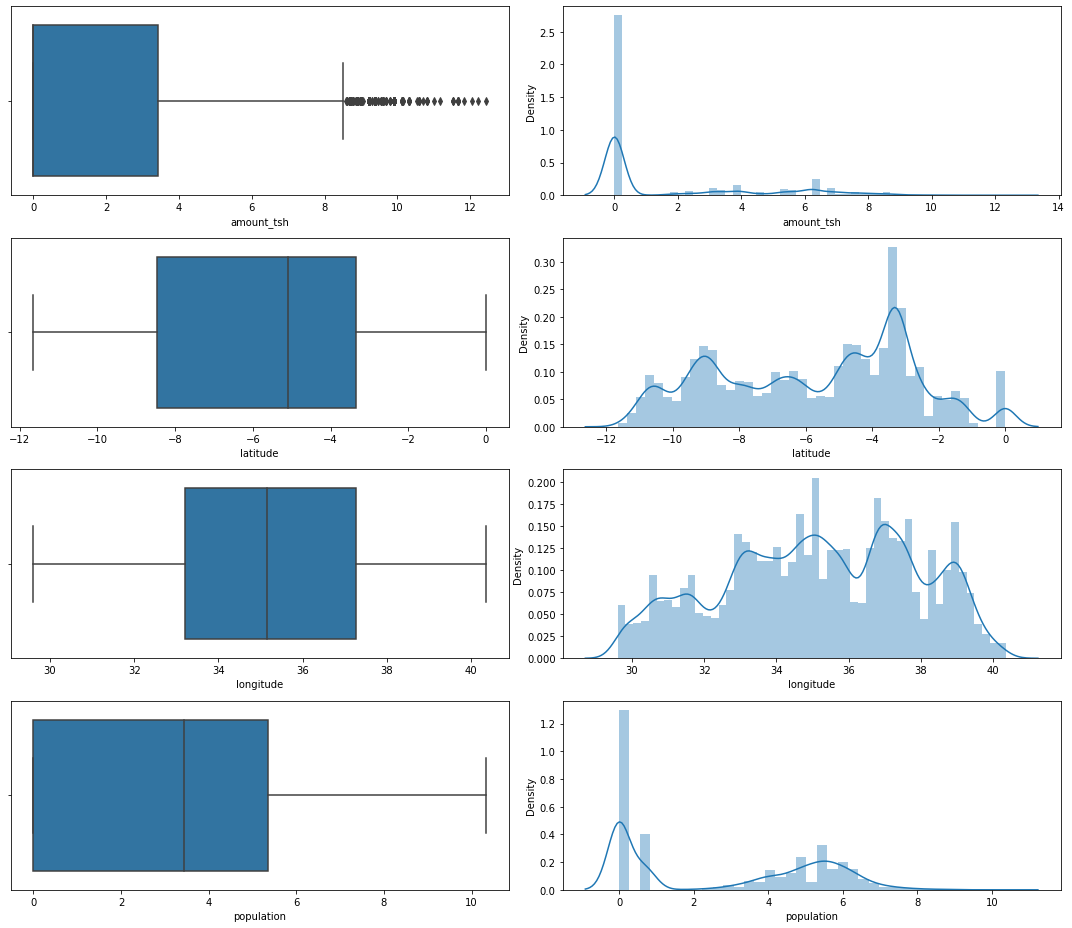

In [100]:
## outlier detection and treatment
# log transformation on skewed data so it more resembles normal distribution
water_pumps_df['population'] = (water_pumps_df['population']+1).transform(np.log)
water_pumps_df['amount_tsh'] = (water_pumps_df['amount_tsh']+1).transform(np.log)

# check boxplots and density plots
numeric_columns = ['amount_tsh', 'latitude', 'longitude', 'population']
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
for i, col in enumerate(numeric_columns):
    sns.boxplot(x= water_pumps_df[col], ax = ax[i,0])
    sns.distplot(water_pumps_df[col], ax = ax[i,1])
plt.tight_layout()

# bin features with clear distinctive distribution
water_pumps_df['amount_tsh'] = pd.cut(x=water_pumps_df['amount_tsh'], 
    bins=[-1, 5, np.inf], 
    labels=['Low', 'High'])

print(water_pumps_df.head())

In [ ]:
# One hot encoding on category variables
# encoded_columns = pd.get_dummies(data['column'])
# data = data.join(encoded_columns).drop('column', axis=1)

In [ ]:
## FEATURE ENGINEERING